In [1]:
import os
import psycopg2
import pandas as pd
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib
import contextily as ctx
import shapely
import json
import numpy as np
from decouple import config

from functions import *

## Connect to Postgres data base
To connect to the postgres database, you should have a text file called `.env` in the same directory as the notebook, containing the user and password information for the database as:
```
POSTGRES_USER=user_name
POSTGRES_KEY=password
```

In [2]:
POSTGRES_USER = config('POSTGRES_USER')
POSTGRES_KEY = config('POSTGRES_KEY')
THUNDERFOREST_KEY = config('THUNDERFOREST_KEY')
ctx.providers.Thunderforest.Outdoors['apikey'] = THUNDERFOREST_KEY

Then we make the connection to the specific database using the `psycopg2.connect()` function:

In [3]:
conn = psycopg2.connect(
   database="nepal", user=POSTGRES_USER, password=POSTGRES_KEY
)

In [5]:
base_map = 'data/neapal_basemap.tif'
scenario = 'Scenario 6'
os.makedirs(os.path.join('maps', scenario), exist_ok=True)

## Reading vector layers
Now that we have connection to the database we can read vector layers stored in it. For that, we can use the library `geopandas` passing an SQL string to the `gpd.read_postgis()` function. This SQL string needs to specify which rows we want to read from an specific table (the `*` indicates all). the structure follow the next logic:
```
'SELECT * FROM schema.table_name'
```
The schema works like a folder containing tables (i.e. layers) inside the database, whereas the table name should be writen exactly as the registered name in the database. If such name uses capital letters, then you should enclose the name inside double coutes as `'SELECT * FROM schema."Table_Name"'`.

In [7]:
sql = 'SELECT * FROM admin.npl_admbnda_adm0_nd_20201117'
df_adm0 = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM admin.npl_admbnda_adm1_nd_20201117'
df_adm1 = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM admin.npl_admbnda_adm2_nd_20201117'
df_adm2 = gpd.read_postgis(sql, conn)
df_adm1['id'] = df_adm1.index
sql = 'SELECT * FROM admin.npl_admbnda_districts_nd_20201117'
df_dist = gpd.read_postgis(sql, conn)

In [8]:
sql = 'SELECT * FROM power_network.substations_georeferenced'
df_sub = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.hv_lines_georeferenced'
df_hv = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.micro_hydropower'
df_mh = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.distribution_coverage'
df_dist = gpd.read_postgis(sql, conn)

In [9]:
sql = 'SELECT * FROM places.education_facilities'
df_edu = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM places.health_facilities'
df_health = gpd.read_postgis(sql, conn)

## Loading population density data

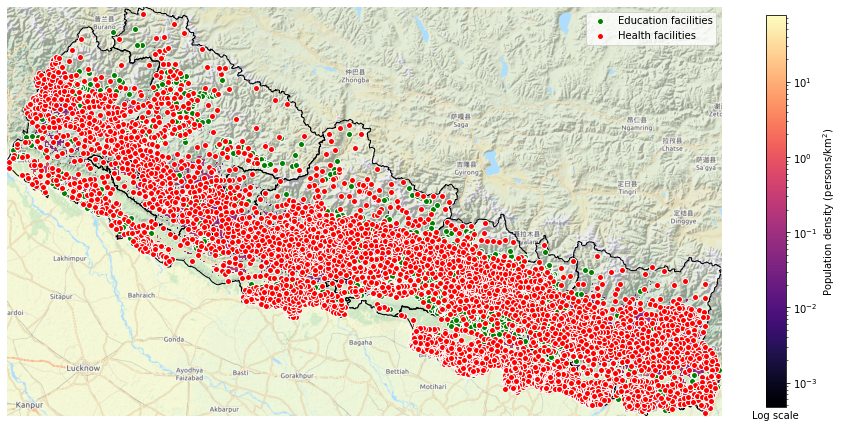

In [13]:
base_layer = 'data/population_npl_2018-10-01_1km.tif'
with rasterio.open(base_layer) as src:
    raster = src.read(1)
    raster[raster==0] = np.nan
#     raster[raster>0] = np.log(raster[raster>0])
    raster = np.nan_to_num(raster, nan=0)
    raster[raster<0] = np.nan
    
with rasterio.open(base_layer) as src:
    bounds = src.bounds
    extent = [bounds[0], bounds[2], bounds[1], bounds[3]] # [left, right, bottom, top]
    raster = src.read(1)
    raster[raster<0] = np.nan
    raster /= 1000
    
with rasterio.open(base_map) as src:
    fig, ax = plt.subplots(1,1, figsize=(16, 9))
    show(src, ax=ax)
    
df_adm1.to_crs(epsg=3857).boundary.plot(color='black', linewidth=1, ax=ax, zorder=1)
df_edu.to_crs(epsg=3857).plot(color='green', alpha=1, linewidth=1, 
                              edgecolor='white', ax=ax, label='Education facilities')
df_health.to_crs(epsg=3857).plot(color='red', ax=ax,  linewidth=1, edgecolor='white',
                                 label='Health facilities', zorder=10)

im = ax.imshow(raster, cmap='magma', extent=extent, norm=matplotlib.colors.LogNorm())
cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.set_ylabel('Population density (persons/km$^2$)')
cbar.ax.set_xlabel('Log scale')
ax.legend(loc="upper right")
ax.set_axis_off()
# plt.title('Clean cooking demand index\nDemand: Educational facilities and population')
fig.savefig(f"maps/{scenario}/demand.png", dpi=300, bbox_inches='tight')

## Plotting the electricity infrastructure

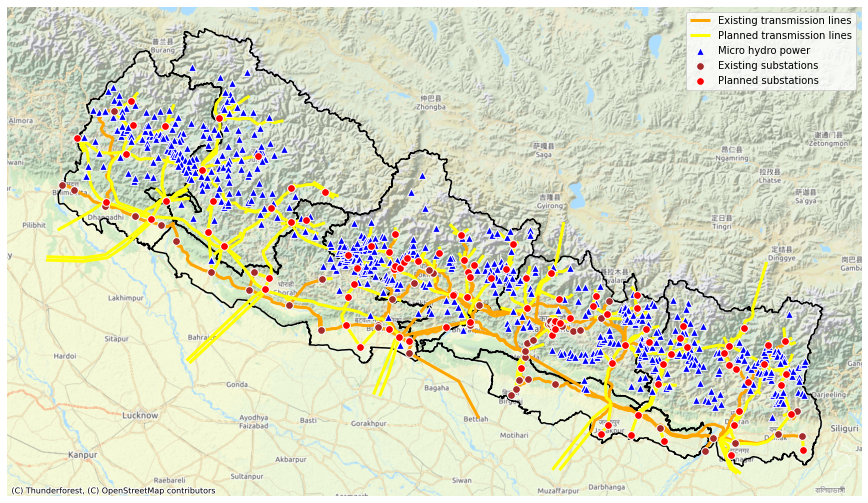

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
df_adm1.to_crs(epsg=3857).boundary.plot(color='black', ax=ax, zorder=1)
df_hv.loc[df_hv['status']=='E'].to_crs(epsg=3857).plot(color='orange', linewidth=3, ax=ax, label='Existing transmission lines')
df_hv.loc[df_hv['status']=='P'].to_crs(epsg=3857).plot(color='yellow', linewidth=3, ax=ax, label='Planned transmission lines')
df_mh.to_crs(epsg=3857).plot(marker="^", color='blue', linewidth=1, markersize=60,
                             edgecolor='white', ax=ax, label='Micro hydro power', zorder=10)
# # df_dist.to_crs(epsg=3857).plot(column='voltage', cmap='Set2', ax=ax, label='Distribution coverage')
df_sub.loc[df_sub['status']=='E'].to_crs(epsg=3857).plot(color='brown', ax=ax,  linewidth=1, edgecolor='white',
                                                         markersize=60, label='Existing substations', zorder=10)
df_sub.loc[df_sub['status']=='P'].to_crs(epsg=3857).plot(color='red', ax=ax,  linewidth=1, edgecolor='white',
                                                         markersize=60, label='Planned substations', zorder=10)
ctx.add_basemap(ax, source=ctx.providers.Thunderforest.Outdoors)
ax.set_axis_off()
plt.legend(loc="upper right")
fig.savefig(f"maps/{scenario}/elec_infra.png", dpi=300, bbox_inches='tight')

## MCA analysis

### Calculating proximity to education facilities

In [52]:
rasterize(df_edu.to_crs(3857), base_layer, 'temp/rasterized_edu.tif', 
          compression='DEFLATE')
proximity_raster('temp/rasterized_edu.tif', 'temp/output_edu.tif', [1], 'DEFLATE')
mask_raster('temp/output_edu.tif', df_adm0.to_crs(3857), 
            'temp/output_masked_edu.tif', -9999, 'DEFLATE')

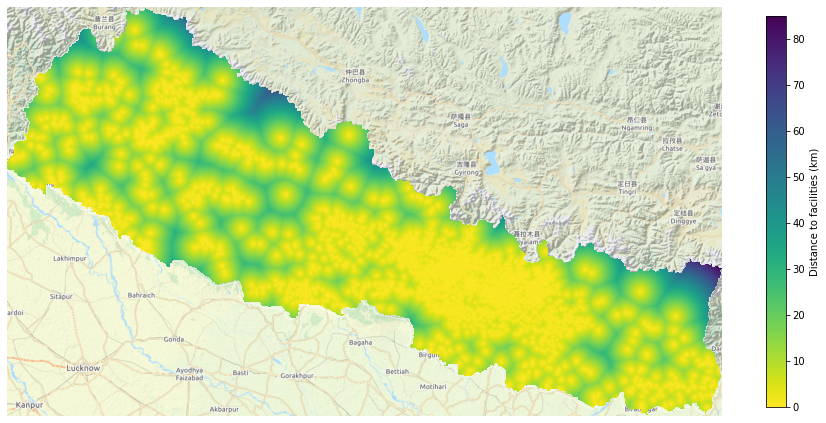

In [53]:
with rasterio.open(base_map) as src:
    fig, ax = plt.subplots(1,1, figsize=(16, 9))
    show(src, ax=ax)
    
with rasterio.open('temp/output_masked_edu.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    raster /= 1000

cax = ax.imshow(raster, extent=extent, cmap='viridis_r')
cbar = fig.colorbar(cax, shrink=0.8)
cbar.ax.set_ylabel('Distance to facilities (km)')
ax.set_axis_off()

# plt.title('Clean cooking demand index\nDemand: Educational facilities and population')
# fig.savefig("maps/dist_to_edu.png", dpi=300, bbox_inches='tight')

### Calculating proximity to health facilities

In [54]:
rasterize(df_health.to_crs(3857), base_layer, 'temp/rasterized_health.tif', 
          compression='DEFLATE')
proximity_raster('temp/rasterized_health.tif', 'temp/output_health.tif', [1], 'DEFLATE')
mask_raster('temp/output_health.tif', df_adm0.to_crs(3857), 
            'temp/output_masked_health.tif', -9999, 'DEFLATE')

### Calculating demand index

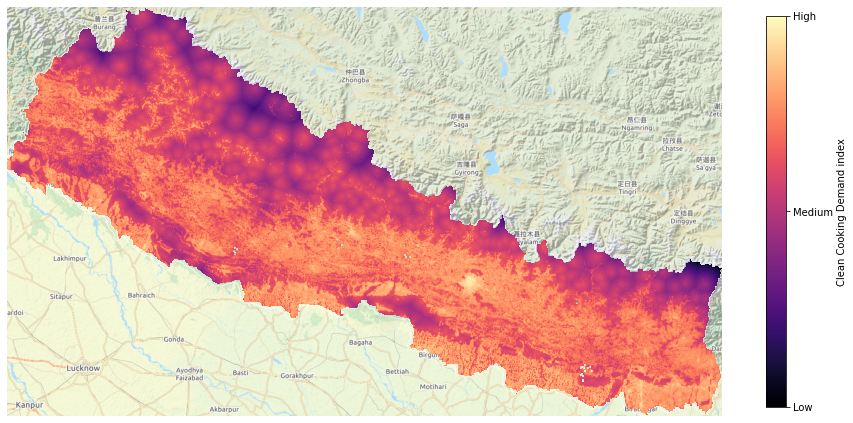

In [14]:
with rasterio.open(base_layer) as src:
    population = src.read(1)
    population[population==0] = np.nan
    population[population>0] = np.log(population[population>0])
    population = np.nan_to_num(population, nan=0)
    population[population<0] = np.nan

    population = population / (np.nanmax(population) - np.nanmin(population))
#     population = np.nan_to_num(population, nan=0)
    
with rasterio.open(base_map) as src:
    fig, ax = plt.subplots(1,1, figsize=(16, 9))
    show(src, ax=ax)

rasters = [
    1 - normalize('temp/output_masked_edu.tif'),
    1 - normalize('temp/output_masked_health.tif'),
    population
]
weights = [
    1,
    1,
    1
]

demand_index = index(rasters, weights)
    
cax = ax.imshow(demand_index, extent=extent, cmap='magma', vmin=0, vmax=1)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
cbar.ax.set_ylabel('Clean Cooking Demand index')
ax.set_axis_off()
# plt.title('Clean cooking demand index\nDemand: Educational facilities and population')
fig.savefig(f"maps/{scenario}/demand_index.png", dpi=300, bbox_inches='tight')

### Calculating proximity to existing transmission substations

In [56]:
rasterize(df_sub.to_crs(3857).loc[df_sub['status']=='E'], base_layer, 
          'temp/rasterized_sub.tif', compression='DEFLATE')
proximity_raster('temp/rasterized_sub.tif', 'temp/output_sub.tif', [1], 'DEFLATE')
mask_raster('temp/output_sub.tif', df_adm0.to_crs(3857), 
            'temp/output_masked_sub.tif', -9999, 'DEFLATE')

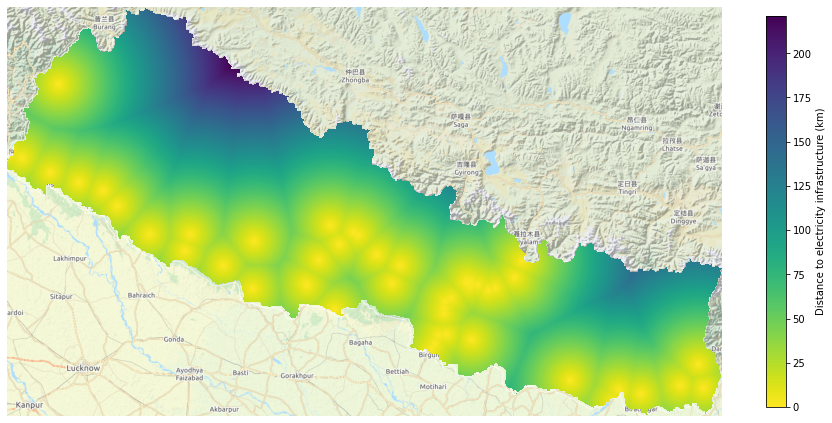

In [57]:
with rasterio.open('temp/output_masked_sub.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    raster /= 1000

with rasterio.open(base_map) as src:
    fig, ax = plt.subplots(1,1, figsize=(16, 9))
    show(src, ax=ax)
    
plt.imshow(raster, extent=extent, cmap='viridis_r')
cbar = plt.colorbar(shrink=0.8)
cbar.ax.set_ylabel('Distance to electricity infrastructure (km)')
ax.set_axis_off()

### Calculating proximity to planned transmission substations

In [16]:
rasterize(df_sub.to_crs(3857).loc[df_sub['status']=='P'], base_layer, 
          'temp/rasterized_subp.tif', compression='DEFLATE')
proximity_raster('temp/rasterized_subp.tif', 'temp/output_subp.tif', [1], 'DEFLATE')
mask_raster('temp/output_subp.tif', df_adm0.to_crs(3857), 
            'temp/output_masked_subp.tif', -9999, 'DEFLATE')

### Calculating proximity to existing HV lines

In [58]:
df_hv_buffer = df_hv.copy().to_crs(3857)
df_hv_buffer['geom'] = df_hv_buffer['geom'].buffer(1)

rasterize(df_hv_buffer.loc[df_hv_buffer['status']=='E'], base_layer, 'temp/rasterized_hv.tif', 
          value='voltage', compression='DEFLATE', dtype='uint16', all_touched=True)
proximity_raster('temp/rasterized_hv.tif', 'temp/output_hv.tif', [132, 220, 400], 'DEFLATE')
mask_raster('temp/output_hv.tif', df_adm0.to_crs(3857), 
            'temp/output_masked_hv.tif', -9999, 'DEFLATE')

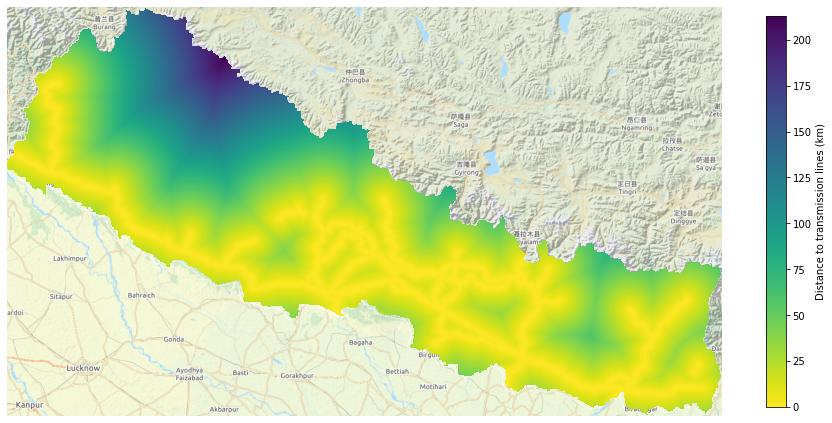

In [59]:
with rasterio.open('temp/output_masked_hv.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    raster /= 1000
    
with rasterio.open(base_map) as src:
    fig, ax = plt.subplots(1,1, figsize=(16, 9))
    show(src, ax=ax)

plt.imshow(raster, extent=extent, cmap='viridis_r')
cbar = plt.colorbar(shrink=0.8)
cbar.ax.set_ylabel('Distance to transmission lines (km)')
ax.set_axis_off()
# fig.savefig("maps/dist_to_hv.png", dpi=300, bbox_inches='tight')

### Calculating proximity to planned HV lines

In [15]:
df_hv_buffer = df_hv.copy().to_crs(3857)
df_hv_buffer['geom'] = df_hv_buffer['geom'].buffer(1)

rasterize(df_hv_buffer.loc[df_hv_buffer['status']=='P'], base_layer, 'temp/rasterized_hvp.tif', 
          value='voltage', compression='DEFLATE', dtype='uint16', all_touched=True)
proximity_raster('temp/rasterized_hvp.tif', 'temp/output_hvp.tif', [132, 220, 400], 'DEFLATE')
mask_raster('temp/output_hvp.tif', df_adm0.to_crs(3857), 
            'temp/output_masked_hvp.tif', -9999, 'DEFLATE')

### Calculating proximity to micro hydro power

In [60]:
rasterize(df_mh.to_crs(3857), base_layer, 
          'temp/rasterized_mh.tif', compression='DEFLATE')
proximity_raster('temp/rasterized_mh.tif', 'temp/output_mh.tif', [1], 'DEFLATE')
mask_raster('temp/output_mh.tif', df_adm0.to_crs(3857), 
            'temp/output_masked_mh.tif', -9999, 'DEFLATE')

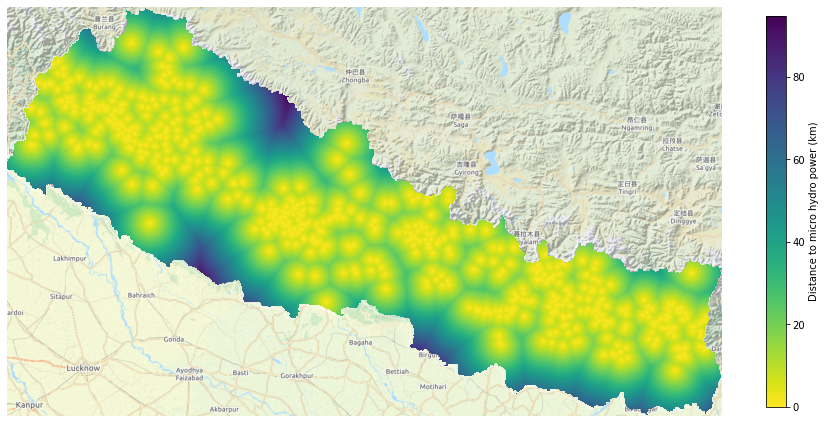

In [61]:
with rasterio.open('temp/output_masked_mh.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    raster /= 1000

with rasterio.open(base_map) as src:
    fig, ax = plt.subplots(1,1, figsize=(16, 9))
    show(src, ax=ax)
    
plt.imshow(raster, extent=extent, cmap='viridis_r')
cbar = plt.colorbar(shrink=0.8)
cbar.ax.set_ylabel('Distance to micro hydro power (km)')
ax.set_axis_off()
# fig.savefig(f"maps/{scenario}/dist_to_mh.png", dpi=300, bbox_inches='tight')

### Calculating supply index

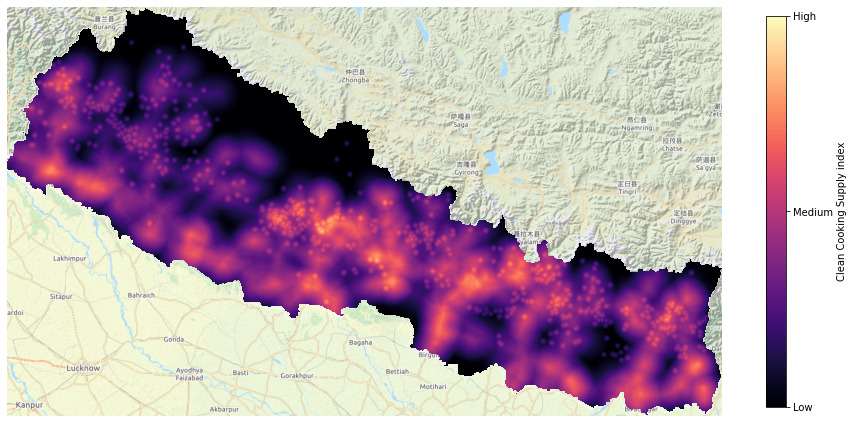

In [26]:
rasters = [
    1 - normalize('temp/output_masked_mh.tif', limit=5000),
    1 - normalize('temp/output_masked_sub.tif', limit=30000), 
    1 - normalize('temp/output_masked_hv.tif', limit=30000),
    1 - normalize('temp/output_masked_subp.tif', limit=30000), 
    1 - normalize('temp/output_masked_hvp.tif', limit=30000)
]
weights = [
    1, 
    1,
    1,
    1,
    1
]

supply_index = index(rasters, weights)

with rasterio.open(base_map) as src:
    fig, ax = plt.subplots(1,1, figsize=(16, 9))
    show(src, ax=ax)
    
cax = ax.imshow(supply_index, extent=extent, cmap='magma', vmin=0, vmax=1)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
cbar.ax.set_ylabel('Clean Cooking Supply index')
ax.set_axis_off()
fig.savefig(f"maps/{scenario}/supply_index.png", dpi=300, bbox_inches='tight')

### Calculating the Clean Cooking Potential index

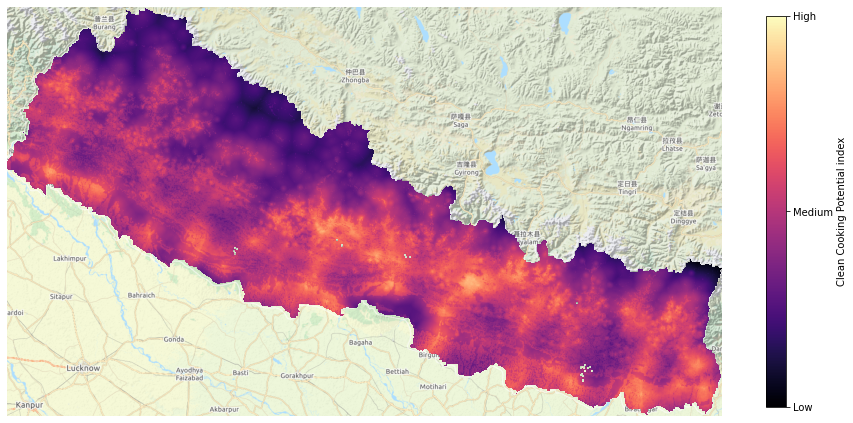

In [27]:
w_s = 1
w_d = 1
ccp_index = (w_s * supply_index + w_d * demand_index) / (w_s + w_d)

with rasterio.open(base_map) as src:
    fig, ax = plt.subplots(1,1, figsize=(16, 9))
    show(src, ax=ax)
    
cax = ax.imshow(ccp_index, extent=extent, cmap='magma', vmin=0, vmax=1)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
cbar.ax.set_ylabel('Clean Cooking Potential index')
ax.set_axis_off()
# plt.title('Clean cooking potential index\nDemand: Educational facilities and population\nSupply: HV lines and transmission Substations')
fig.savefig(f"maps/{scenario}/clean_cooking_potential.png", dpi=300, bbox_inches='tight')

### Saving results

In [64]:
with rasterio.open(base_layer) as src:
    out_meta = src.meta

with rasterio.open(f"maps/{scenario}/ccp_index.tif', "w", **out_meta) as dest:
    dest.write(ccp_index, indexes=1)

## Prioritizing areas 

In [65]:
sql = 'SELECT * FROM cooking_fuels.wood'
df_wood = gpd.read_postgis(sql, conn)

Text(0.5, 1.0, 'Amount of households cooking with firewood per municipality')

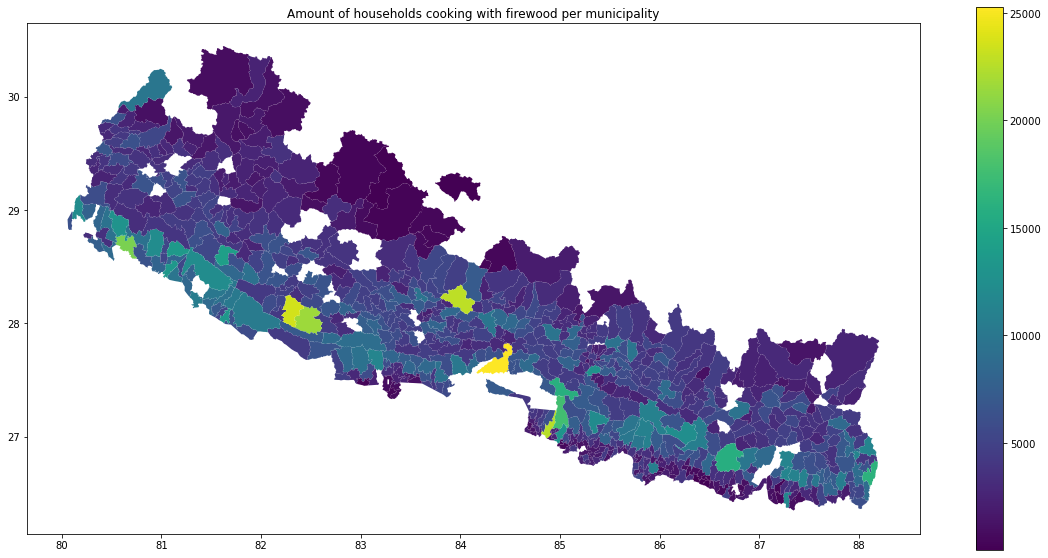

In [66]:
df_wood.plot(column='Wood / Firewood', legend=True, figsize=(20, 10))
plt.title('Amount of households cooking with firewood per municipality')

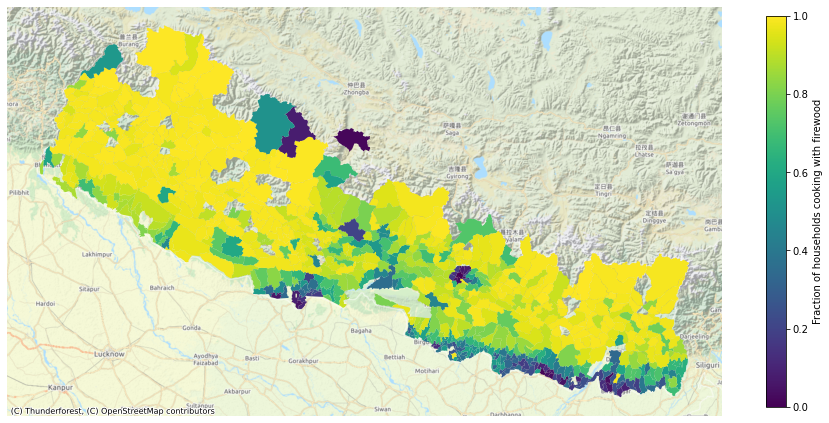

In [67]:
df_wood['percentage'] = df_wood['Wood / Firewood'] / df_wood['Total households'] * 100

fig, ax = plt.subplots(1, 1, figsize=(16, 9))

cax = df_wood.to_crs(epsg=3857).plot(column='percentage', ax=ax, legend=False)
ctx.add_basemap(ax, source=ctx.providers.Thunderforest.Outdoors)
sm = plt.cm.ScalarMappable()
cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.set_ylabel('Fraction of households cooking with firewood')
ax.set_axis_off()
# plt.title('Percentage of households cooking with firewood per municipality')
# fig.savefig(f"maps/{scenario}cooking_firewood.png", dpi=300, bbox_inches='tight')

In [68]:
df_wood_filtered = df_wood.loc[df_wood['percentage']>=80].to_crs(3857)
mask_raster('maps/Scenario 5/ccp_index.tif', df_wood_filtered, 
            'maps/Scenario 5/ccp_index_filtered.tif', np.nan, 'DEFLATE')

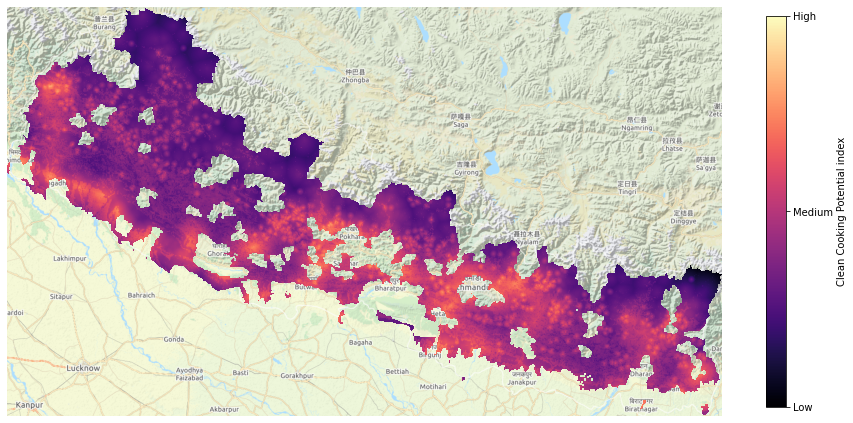

In [70]:
with rasterio.open('maps/Scenario 5/ccp_index_filtered.tif') as src:
    raster = src.read(1)
    
with rasterio.open(base_map) as src:
    fig, ax = plt.subplots(1,1, figsize=(16, 9))
    show(src, ax=ax)

cax = ax.imshow(raster, extent=extent, cmap='magma', vmin=0, vmax=1)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
cbar.ax.set_ylabel('Clean Cooking Potential index')
ax.set_axis_off()
fig.savefig(f"maps/{scenario}ccp_index_filtered.png", dpi=300, bbox_inches='tight')
# plt.title('Clean cooking potential index\nDemand: Educational facilities and population\nSupply: HV lines and transmission Substations\nPrioritized for municipalities where more that 80% of households use firewood for cooking')